# Comparison of levelsets for fgsm defense and l2 defense training

In [6]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
seed = 56
# torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

56



## Data preparation

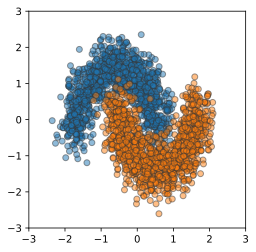

In [7]:
data_noise = 0.2
plotlim = [-3, 3]
subfolder = 'levelset_dbstyle'


from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('moons', noise = data_noise, plotlim = plotlim, random_state = seed)


## Model dynamics

In [8]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 15, 15 
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = True
turnpike = False

non_linearity = 'tanh' #'relu' #
architecture = 'inside' #outside


## Training and generating level sets

In [9]:

num_epochs = 120 #number of optimization runs in which the dataset is used for gradient decent
eps = 0.2

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
rnode_fgsm = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_rnode_fgsm = torch.optim.Adam(rnode_fgsm.parameters(), lr=1e-3) 

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
rnode_l2 = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_rnode_l2 = torch.optim.Adam(rnode_l2.parameters(), lr=1e-3) 

In [10]:
from models.training import doublebackTrainer

trainer_rnode_fgsm = doublebackTrainer(rnode_fgsm, optimizer_rnode_fgsm, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = eps, db_type = 'fgsm') 
trainer_rnode_fgsm.train(dataloader, num_epochs)


Iteration 0/38
Loss: 0.417
Robust Term Loss: 0.073
Accuracy: 0.844

Iteration 10/38
Loss: 0.411
Robust Term Loss: 0.097
Accuracy: 0.859

Iteration 20/38
Loss: 0.523
Robust Term Loss: 0.101
Accuracy: 0.766

Iteration 30/38
Loss: 0.400
Robust Term Loss: 0.064
Accuracy: 0.812
Epoch 1: 0.406

Iteration 0/38
Loss: 0.356
Robust Term Loss: 0.101
Accuracy: 0.906

Iteration 10/38
Loss: 0.447
Robust Term Loss: 0.096
Accuracy: 0.781

Iteration 20/38
Loss: 0.325
Robust Term Loss: 0.086
Accuracy: 0.922

Iteration 30/38
Loss: 0.441
Robust Term Loss: 0.114
Accuracy: 0.844
Epoch 2: 0.366

Iteration 0/38
Loss: 0.366
Robust Term Loss: 0.097
Accuracy: 0.875

Iteration 10/38
Loss: 0.338
Robust Term Loss: 0.073
Accuracy: 0.891

Iteration 20/38
Loss: 0.312
Robust Term Loss: 0.091
Accuracy: 0.922

Iteration 30/38
Loss: 0.236
Robust Term Loss: 0.052
Accuracy: 0.953
Epoch 3: 0.346

Iteration 0/38
Loss: 0.297
Robust Term Loss: 0.068
Accuracy: 0.922

Iteration 10/38
Loss: 0.319
Robust Term Loss: 0.087
Accuracy:

In [11]:
#We are training the last linear layer for the standard model and then use the same for the robust model for better comparison   
w = rnode_fgsm.linear_layer.weight
b = rnode_fgsm.linear_layer.bias

print(w)
print(b)

rnode_l2.linear_layer.weight = w
rnode_l2.linear_layer.bias = b

rnode_l2.linear_layer.requires_grad =  False

Parameter containing:
tensor([[-0.3791, -0.2396],
        [ 0.2988, -0.8020]], requires_grad=True)
Parameter containing:
tensor([-0.7371,  0.3239], requires_grad=True)


In [12]:
trainer_rnode_l2 = doublebackTrainer(rnode_l2, optimizer_rnode_l2, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = eps, db_type = 'l2') 
trainer_rnode_l2.train(dataloader, num_epochs)




Iteration 0/38
Loss: 0.371
Robust Term Loss: 0.034
Accuracy: 0.812

Iteration 10/38
Loss: 0.221
Robust Term Loss: 0.021
Accuracy: 0.922

Iteration 20/38
Loss: 0.341
Robust Term Loss: 0.037
Accuracy: 0.812

Iteration 30/38
Loss: 0.307
Robust Term Loss: 0.030
Accuracy: 0.859
Epoch 1: 0.296

Iteration 0/38
Loss: 0.344
Robust Term Loss: 0.023
Accuracy: 0.828

Iteration 10/38
Loss: 0.242
Robust Term Loss: 0.027
Accuracy: 0.875

Iteration 20/38
Loss: 0.258
Robust Term Loss: 0.018
Accuracy: 0.859

Iteration 30/38
Loss: 0.274
Robust Term Loss: 0.026
Accuracy: 0.828
Epoch 2: 0.266

Iteration 0/38
Loss: 0.234
Robust Term Loss: 0.020
Accuracy: 0.875

Iteration 10/38
Loss: 0.267
Robust Term Loss: 0.018
Accuracy: 0.844

Iteration 20/38
Loss: 0.275
Robust Term Loss: 0.021
Accuracy: 0.875

Iteration 30/38
Loss: 0.208
Robust Term Loss: 0.025
Accuracy: 0.922
Epoch 3: 0.253

Iteration 0/38
Loss: 0.246
Robust Term Loss: 0.020
Accuracy: 0.875

Iteration 10/38
Loss: 0.275
Robust Term Loss: 0.024
Accuracy:

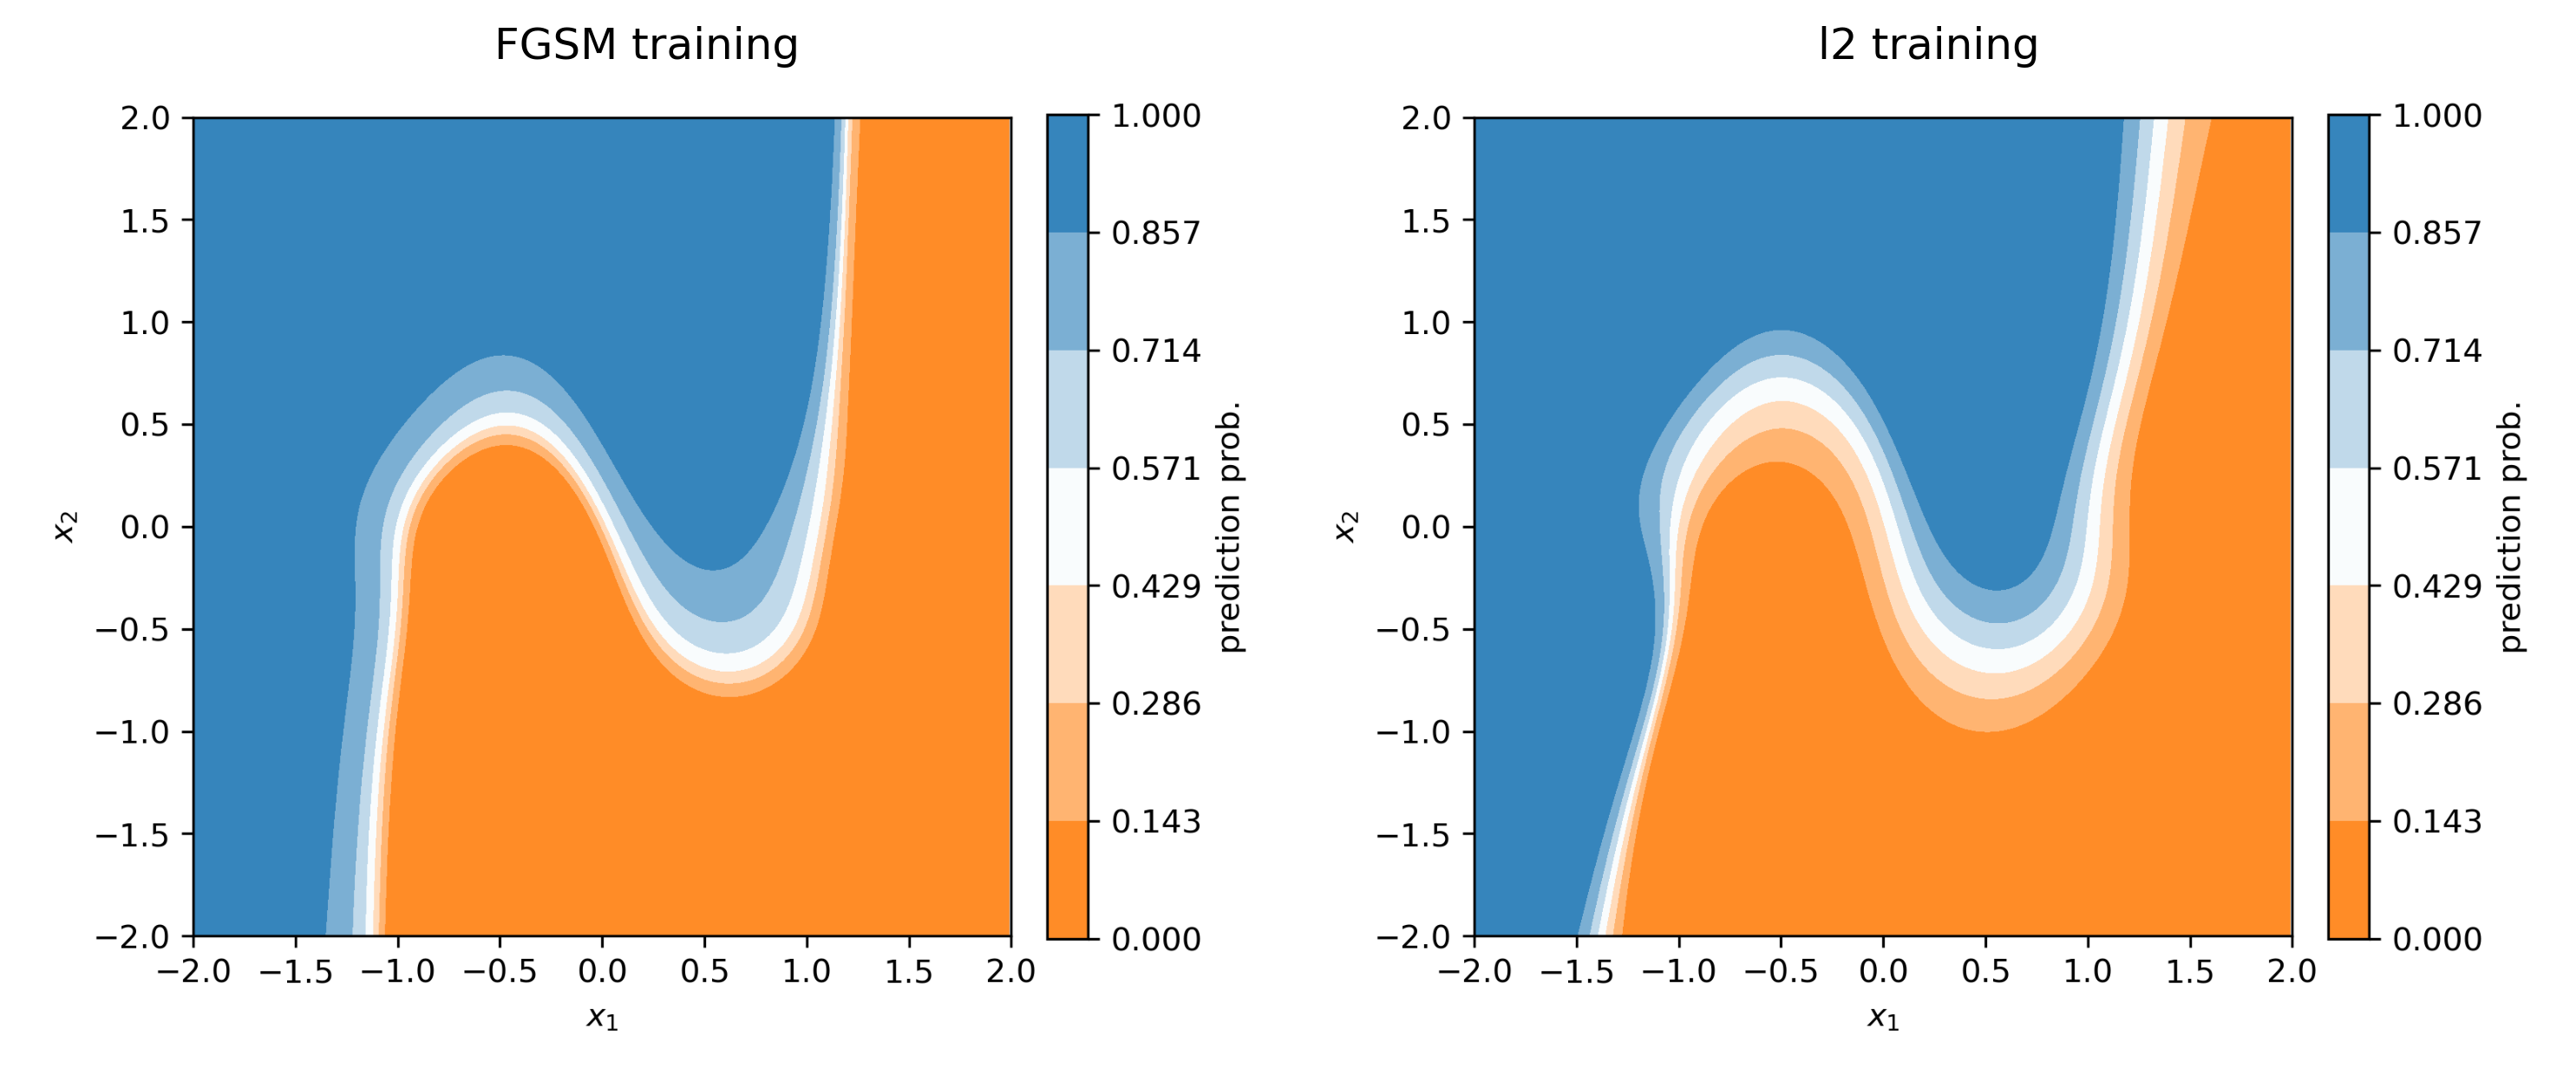

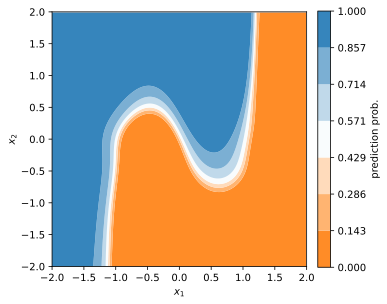

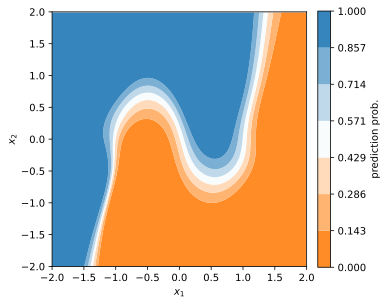

In [14]:
from plots.plots import classification_levelsets, comparison_plot
from IPython.display import Image
import os

if not os.path.exists(subfolder):
        os.makedirs(subfolder)
        
fig_name_base = os.path.join(subfolder, 'levelsets')
fig_name_fgsm = fig_name_base + '_fgsm'
fig_name_l2 = fig_name_base + '_l2'
classification_levelsets(rnode_fgsm, fig_name_fgsm)
classification_levelsets(rnode_l2, fig_name_l2)

comparison_plot(fig_name_fgsm + '.png', 'FGSM training', fig_name_l2 + '.png', 'l2 training', fig_name_base + '_comp.png', figsize=(10,20), dpi = 300)
display(Image(fig_name_base + '_comp.png', width = 800))

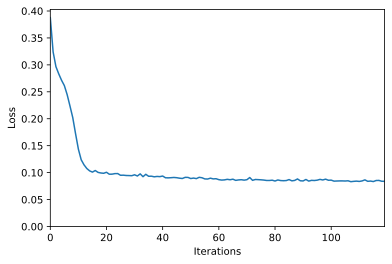

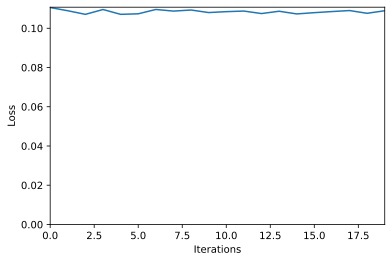

In [ ]:
plt.plot(trainer_rnode_fgsm.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_rnode_fgsm.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

plt.plot(trainer_rnode_fgsm.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_rnode_fgsm.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()